In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time
import scipy as sc

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.GRF_inhomogeneities import *

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
GRF_class=GRF_inhomogeneities(100,0.08,100)

In [3]:
BM_vars=np.zeros((1000,2))
for i in range(1000):
    np.random.seed(i)
    BM_vars[i]=Box_Muller_transform()

<AxesSubplot:>

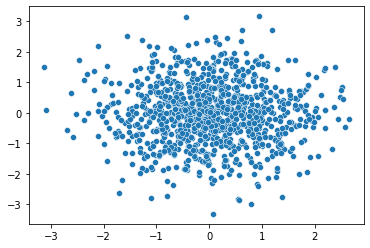

In [4]:
sns.scatterplot(x=BM_vars[:,0],y=BM_vars[:,1])

In [5]:
sc.stats.spearmanr(BM_vars[:,0],BM_vars[:,1])

SpearmanrResult(correlation=-0.006917610917610919, pvalue=0.8270527410868135)

In [6]:
BM_vars[:,1].std()

0.9920004960638594

In [7]:
    def test_potential():

        logA_array=[-9.,-8.,-7.]
        Beta_array=[0,2,4]

        theoretical_Variances=np.zeros((len(logA_array),len(Beta_array),100))
        generated_Variances=np.zeros((len(logA_array),len(Beta_array),100))

        for i,logA in enumerate(logA_array):
            for j,Beta in enumerate(Beta_array):
                #100 variances for each logA,Beta from Parseval's theorem
                theoretical_Variances[i,j]=np.repeat(GRF_class.field_variance([logA,Beta],field='potential'),100)
                #100 variances for each logA,Beta from actually sampled field
                Potentials = np.array([GRF_class.potential([logA,Beta],GRF_class.tensor_unit_Fourier_images[seed])\
                                       for seed in range(100)])
                generated_Variances[i,j]=Potentials.var(axis=(-1,-2))
    
        return theoretical_Variances,generated_Variances

In [8]:
theoretical_Variances,generated_Variances=test_potential()

In [9]:
q=np.abs(np.log(generated_Variances)-np.log(theoretical_Variances))

In [33]:
q=(generated_Variances-theoretical_Variances)/np.abs(theoretical_Variances)

(array([618., 105.,  57.,  48.,  30.,  15.,  12.,   6.,   6.,   3.]),
 array([6.79002360e-05, 1.35026222e-01, 2.69984543e-01, 4.04942864e-01,
        5.39901186e-01, 6.74859507e-01, 8.09817828e-01, 9.44776150e-01,
        1.07973447e+00, 1.21469279e+00, 1.34965111e+00]),
 <BarContainer object of 10 artists>)

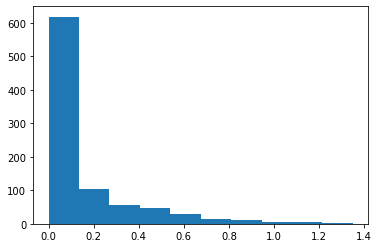

In [10]:
plt.hist(q.flatten())

In [43]:
q.max()

0.224781434299191

In [15]:
  def test_kappa():

        logA_array=[-9.,-8.,-7.]
        Beta_array=[0,2,4]

        theoretical_Variances=np.zeros((len(logA_array),len(Beta_array),100))
        generated_Variances=np.zeros((len(logA_array),len(Beta_array),100))

        for i,logA in enumerate(logA_array):
            for j,Beta in enumerate(Beta_array):
                #100 variances for each logA,Beta from Parseval's theorem
                theoretical_Variances[i,j]=np.repeat(GRF_class.field_variance([logA,Beta],field='kappa'),100)
                #100 variances for each logA,Beta from actually sampled field
                kappas = np.array([GRF_class.kappa([logA,Beta],GRF_class.tensor_unit_Fourier_images[seed])\
                                       for seed in range(100)])
                generated_Variances[i,j]=kappas.var(axis=(-1,-2))
        return theoretical_Variances,generated_Variances

In [16]:
theoretical_Variances,generated_Variances=test_kappa()

In [19]:
q=np.abs(np.log(generated_Variances)-np.log(theoretical_Variances))

(array([228., 201., 150.,  96., 120.,  42.,  36.,  18.,   6.,   3.]),
 array([0.0001015 , 0.00510593, 0.01011036, 0.01511479, 0.02011922,
        0.02512365, 0.03012809, 0.03513252, 0.04013695, 0.04514138,
        0.05014581]),
 <BarContainer object of 10 artists>)

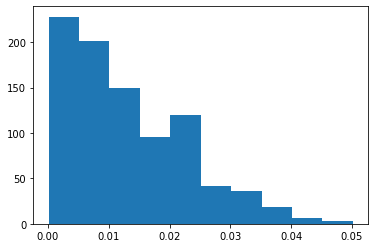

In [20]:
plt.hist(q.flatten())

In [23]:
GRF_class.field_variance??

In [26]:
def checktype(obj):
        return bool(obj) and all(isinstance(elem, str) for elem in obj)

In [28]:
checktype({'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0})

True

In [45]:
def check_model_kwargs(kwargs):
    try:
        is_list=isinstance(kwargs,(list,np.ndarray))
        are_list_dicts=(set(map(type,q))=={dict})
        are_str_keys=([set(map(type,p.keys())) for p in q]==np.repeat({str},len(q)))
        are_float_values=([set(map(type,p.values())) for p in q]==np.repeat({float},len(q)))
        return True
    except:
        raise ValueError('kwargs should be list of dictionaries with string keys and float values')

In [46]:
check_model_kwargs([{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                                                  {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}])

True

In [48]:
q=np.array([{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                                                  {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}])

In [56]:
[key for key in q[0]]

['theta_E', 'e1', 'e2', 'center_x', 'center_y']

In [53]:
q[0]

{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}

array([ True,  True])

In [72]:
q[0].values

<function dict.values>

In [74]:
([set(map(type,p.values)) for p in q]==np.repeat({str},len(q)))

TypeError: 'builtin_function_or_method' object is not iterable

In [78]:
set(map(type,q[0].values()))

{float}

In [77]:
q[0].values()

dict_values([1.6, 0.15, -0.04, 0.0, 0.0])

In [123]:
def check_model_kwargs(kwargs):
    try:
        is_list=isinstance(kwargs,(list,np.ndarray))
        are_list_dicts=(set(map(type,kwargs))=={dict})
        are_str_keys=all([set(map(type,model_dict.keys())) for model_dict in kwargs]==np.repeat({str},len(kwargs)))
        are_float_values=all([set(map(type,model_dict.values())) for model_dict in kwargs]==np.repeat({float},len(kwargs)))
        return (is_list&are_list_dicts&are_str_keys&are_float_values)
    except:
        raise ValueError('kwargs should be a list of dictionaries with string keys and float values')


In [122]:
check_model_kwargs([{'sdsd1': 2.}])

True

In [116]:
check_model_kwargs(None)

ValueError: kwargs should be list of dictionaries with string keys and float values

In [95]:
kwargs=q

In [97]:
all([set(map(type,model_dict.keys())) for model_dict in kwargs]==np.repeat({str},len(kwargs)))

True

In [102]:
([set(map(type,model_dict.values())) for model_dict in kwargs]==np.repeat({float},len(kwargs)))

array([ True,  True])

In [103]:
all(([set(map(type,model_dict.values())) for model_dict in kwargs]==np.repeat({float},len(kwargs))))

True

In [105]:
True & True

True

In [106]:
not True

False

In [261]:
def check_model(model,kwargs):
    #Empty model 
    if model==[] and kwargs==[{}]:
        return True
    
    try:
        if not (set(map(type,model))=={str}):
            raise
    except:
        raise ValueError('model should be list/array of strings')
    
    try:
        key_types=[set(map(type,model_dict.keys())) for model_dict in kwargs]
        value_types=[set(map(type,model_dict.values())) for model_dict in kwargs]
        are_str_keys=set().union(*key_types)=={str}
        are_numeric_values=set().union(*value_types).issubset({float,int})
        if not are_str_keys&are_numeric_values:
            raise
    except:
        raise ValueError('kwargs should be a list/array of dictionaries with string keys and float values')

    if not len(model)==len(kwargs):
        raise ValueError('Model list and kwargs list have different length')
        
    return True

In [257]:
#Default models of source galaxy and lens galaxy
default_source_light_model_list = ['SERSIC_ELLIPSE']
default_lens_mass_model_list = ['SIE', 'SHEAR']
default_lens_light_model_list = []

#Default model parameters of source galaxy and lens galaxy
default_unperturbed_model_kwargs={'kwargs_lens': [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                                                  {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}],
                                  'kwargs_source': [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}],
                                  'kwargs_lens_light': [{}]}

In [216]:
check_model([],[{}])

True

In [217]:
check_model(default_source_light_model_list,default_unperturbed_model_kwargs['kwargs_source'])

True

In [218]:
check_model(default_lens_mass_model_list,default_unperturbed_model_kwargs['kwargs_lens'])

True

In [219]:
check_model(default_lens_light_model_list,default_unperturbed_model_kwargs['kwargs_lens_light'])

True

In [267]:
check_model(['11','1'],[{'s':0.,"a":1},{"1":0.}])

True

In [269]:
check_model(['11','1'],[{'s':0.}])

ValueError: Model list and kwargs list have different length

In [270]:
check_model([],[{}])

True

In [221]:
default_unperturbed_model_kwargs['kwargs_lens_light']

[{}]

In [245]:
np.isin([{float}, {None}],[float,int])

array([False, False])

In [177]:
kwargs=default_unperturbed_model_kwargs['kwargs_lens_light']
all([set(map(type,model_dict.keys())) for model_dict in kwargs]==np.repeat({str},len(kwargs)))

False

In [202]:

set(map(type,default_lens_mass_model_list))=={str}

True

In [246]:
type([''])

list

In [251]:
kwargs=[{'s':0,'a':None},{'1':1.}]
x=[set(map(type,model_dict.values())) for model_dict in kwargs]
set().union(*x)

{NoneType, float, int}

In [255]:
{int,float}.difference({float})

AttributeError: 'dict' object has no attribute 'issubset'

In [193]:
x

[{str}, {str}]

In [199]:
set().union(*x)

set()

In [184]:
np.concatenate([set(map(type,model_dict.keys())) for model_dict in kwargs])

ValueError: zero-dimensional arrays cannot be concatenated

In [178]:
[set(map(type,model_dict.keys())) for model_dict in kwargs]

[set()]

In [180]:
np.repeat({str},len(kwargs))

array([{<class 'str'>}], dtype=object)

In [ ]:
check_model(default_lens_light_model_list,default_unperturbed_model_kwargs['kwargs_lens_light'])

In [176]:
default_unperturbed_model_kwargs['kwargs_lens_light']

[{}]

In [209]:
kwargs[0].values

<function dict.values>

In [271]:
from herculens.LensImage.lens_image import LensImage

In [272]:
LensImage?

In [273]:
np.array([1,2,3])<=2

array([ True,  True, False])

In [283]:
del Surface_brightness_class

In [284]:
from GRF_perturbations.Modules.Surface_Brightness import Surface_brightness_class

In [285]:
Surface_brightness=Surface_brightness_class(100,0.08,0.1,200,2028)

In [292]:
simulate_perturbed_image=Surface_brightness.perturbed_image_getter
simulate_unperturbed_image=Surface_brightness.unperturbed_image_getter

In [296]:
GRF_potential=GRF_class.potential([-10,2],GRF_class.tensor_unit_Fourier_images[0])

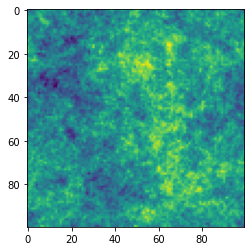

In [297]:
plt.imshow(GRF_potential)

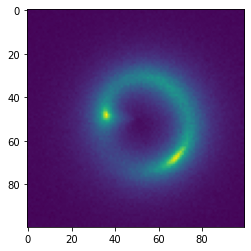

In [298]:
plt.imshow(simulate_perturbed_image(GRF_potential,Noise_flag=True))

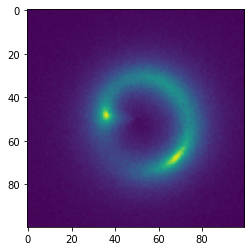

In [295]:
plt.imshow(simulate_unperturbed_image(Surface_brightness.unperturbed_model_kwargs,Noise_flag=True))